In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [8]:
data=pd.read_csv('/Users/harshilkorat/Intern_Task/Fraud.csv')
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
#data.isnull().sum()
data=pd.get_dummies(data,columns=['type'])

print(data.describe())


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [12]:
num_da=data.drop(['nameOrig', 'nameDest'], axis=1)

In [14]:
corrm=num_da.corr(method='pearson')

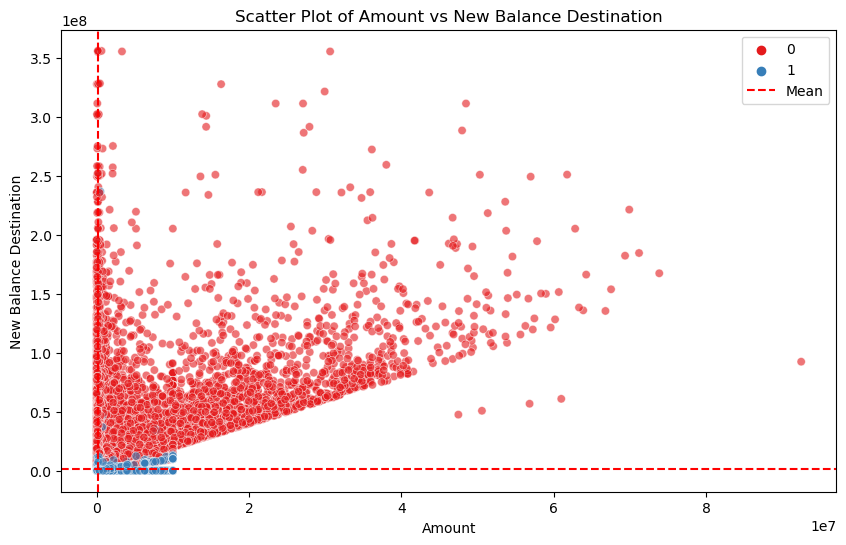

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot for Amount vs New Balance Destination
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='amount', y='newbalanceDest', hue='isFraud', palette='Set1', alpha=0.6)
plt.title('Scatter Plot of Amount vs New Balance Destination')
plt.xlabel('Amount')
plt.ylabel('New Balance Destination')
plt.axhline(y=data['newbalanceDest'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(x=data['amount'].mean(), color='r', linestyle='--')
plt.legend()
plt.show()


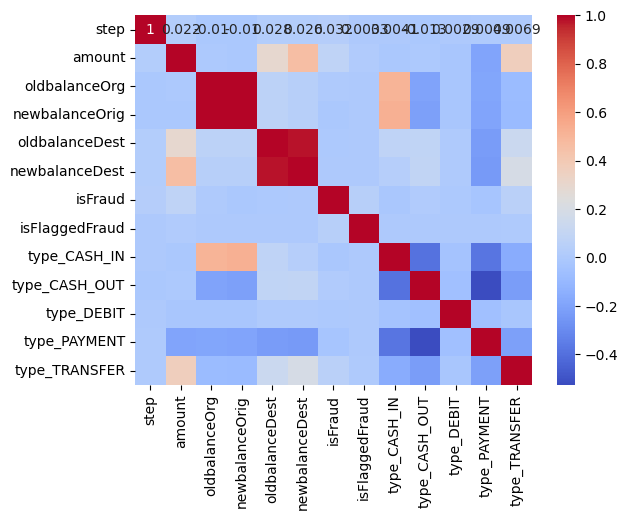

In [11]:
sns.heatmap(corrm, annot=True, cmap = 'coolwarm')

# Show the plot

plt.show()

In [11]:
X=data[['amount','isFlaggedFraud','type_PAYMENT','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_TRANSFER','oldbalanceDest','newbalanceDest']]
y=data['isFraud']

In [4]:



#  necessary libraries
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

#  feature set and target variable
X = data[['amount','type_PAYMENT', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_TRANSFER', 'oldbalanceDest', 'newbalanceDest']]
y = data['isFraud']

# Split data training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize  data to improve model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using RandomUnderSampler 
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_scaled, y_train)

# Define the Random Forest model with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees (balanced between performance and speed)
    max_depth=15,          # Limit tree depth to avoid overly complex trees
    min_samples_split=10,  # Control the minimum number of samples required to split an internal node
    n_jobs=-1,             # Utilize all available cores for faster training
    random_state=42
)

# Perform RandomizedSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [10, 15, 20],   # Depth of trees
    'min_samples_split': [5, 10, 20],  # Minimum samples to split
}

# Randomized search with cross-validation (3-fold for speed)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=5, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_balanced, y_train_balanced)

# Get the best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Train the best model on the full balanced training data
best_rf_model.fit(X_train_balanced, y_train_balanced)

#  predictions on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# model evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC score
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", roc_auc)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance 
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. Feature {X.columns[indices[i]]} ({importances[indices[i]]})")


NameError: name 'data' is not defined

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

# Feature selection (remove isFlaggedFraud due to low importance)
data['amount_to_new_balance_ratio'] = data['amount'] / (data['newbalanceDest'] + 1e-8)  # Adding a small value to avoid division by zero
data['amount_to_old_balance_ratio'] = data['amount'] / (data['oldbalanceDest'] + 1e-8)


X = data[['amount','type_TRANSFER','newbalanceDest','amount_to_new_balance_ratio','amount_to_old_balance_ratio']]
y = data['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for balancing the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=65, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Adjust the threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(precision * recall)  # Find the optimal threshold
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", roc_auc)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.90      0.64      0.75      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.82      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC: 0.9594819439014267
Confusion Matrix:
[[1270794     110]
 [    585    1035]]


In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Precision-Recall curve to explore thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Print precision and recall at different thresholds
for i in range(0, len(thresholds), 10):  # Check at intervals of 10 to reduce output
    print(f"Threshold: {thresholds[i]:.2f}, Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}")

# Set the optimal threshold manually (tune as needed)
optimal_threshold = 0.60  # Adjust this value based on the above results

# Convert probabilities to predictions based on the new threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model with the new threshold
print("Classification Report with Optimized Threshold:")
print(classification_report(y_test, y_pred_optimal))


Threshold: 0.00, Precision: 0.0013, Recall: 1.0000
Threshold: 0.00, Precision: 0.0022, Recall: 1.0000
Threshold: 0.00, Precision: 0.0023, Recall: 1.0000
Threshold: 0.00, Precision: 0.0023, Recall: 1.0000
Threshold: 0.00, Precision: 0.0023, Recall: 1.0000
Threshold: 0.00, Precision: 0.0024, Recall: 1.0000
Threshold: 0.00, Precision: 0.0026, Recall: 0.9994
Threshold: 0.00, Precision: 0.0026, Recall: 0.9994
Threshold: 0.00, Precision: 0.0027, Recall: 0.9994
Threshold: 0.00, Precision: 0.0027, Recall: 0.9994
Threshold: 0.00, Precision: 0.0027, Recall: 0.9994
Threshold: 0.00, Precision: 0.0028, Recall: 0.9994
Threshold: 0.00, Precision: 0.0028, Recall: 0.9994
Threshold: 0.00, Precision: 0.0028, Recall: 0.9994
Threshold: 0.00, Precision: 0.0028, Recall: 0.9994
Threshold: 0.00, Precision: 0.0029, Recall: 0.9994
Threshold: 0.00, Precision: 0.0029, Recall: 0.9994
Threshold: 0.00, Precision: 0.0029, Recall: 0.9994
Threshold: 0.00, Precision: 0.0029, Recall: 0.9994
Threshold: 0.00, Precision: 0.0